In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from scipy.io import loadmat
from adversarial_examples import *
from train_network import *
from plots import *
from li_attack import CarliniLi
from l0_attack import CarliniL0
from l2_attack import CarliniL2
from random import randrange

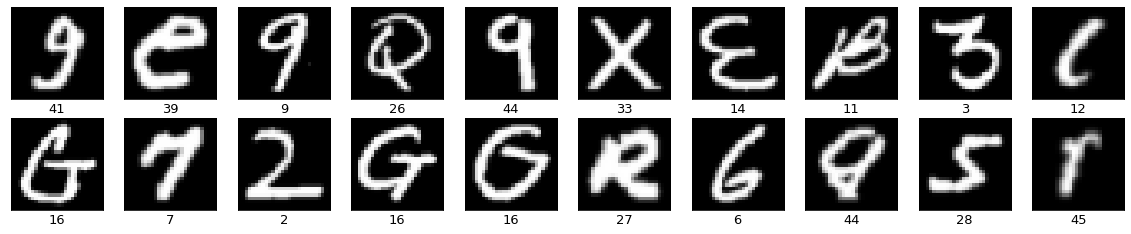

In [4]:
# Extract dataset
variables = dict()
loadmat('emnist-balanced.mat', variables)
data = variables['dataset']

x_train = data['train'][0,0]['images'][0,0]
y_train = data['train'][0,0]['labels'][0,0]
x_val = data['test'][0,0]['images'][0,0]
y_val = data['test'][0,0]['labels'][0,0]

x_train = (x_train/255.0) - 0.5
x_val = (x_val/255.0) - 0.5

# Plot some training examples
plt.figure(figsize=(20,20))
for i in range(20):
    plt.subplot(10,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_val[i].reshape(28, 28, order='F'), cmap=plt.cm.gray)
    label = plt.xlabel(y_val[i][0])
    label.set_size(13)
plt.show()

In [5]:
# Train model with basic neural network
model = train_neural_network(x_train, y_train, 5)

Train on 112800 samples
Epoch 1/5
112800/112800 [==============================] - 7s 62us/sample - loss: 1.1637 - accuracy: 0.6580
Epoch 2/5
112800/112800 [==============================] - 6s 52us/sample - loss: 0.7276 - accuracy: 0.7702
Epoch 3/5
112800/112800 [==============================] - 6s 57us/sample - loss: 0.6299 - accuracy: 0.7960
Epoch 4/5
112800/112800 [==============================] - 7s 65us/sample - loss: 0.5805 - accuracy: 0.8083
Epoch 5/5
112800/112800 [==============================] - 7s 62us/sample - loss: 0.5485 - accuracy: 0.8177


In [6]:
# Test neural network on validation set
y_val_pred = model.predict(x_val)
test_loss, test_acc = model.evaluate(x_val,  y_val, verbose=0)

print('\nTest accuracy:', test_acc)


Test accuracy: 0.8029255


In [7]:
# Adverserial Image Generation

#Targetted Attack
target_label = 46 ## should be one of class labels 0 - 46 ##

label = tf.one_hot(np.repeat(target_label, y_val_pred.shape[0]), y_val_pred.shape[-1])

x_val_adversarial = fgsm_iterative(model, x_val, label, epsilon=0.01, epoch = 10)

x_val_adversarial = x_val_adversarial.numpy()

y_val_adversarial_pred = model.predict(x_val_adversarial)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



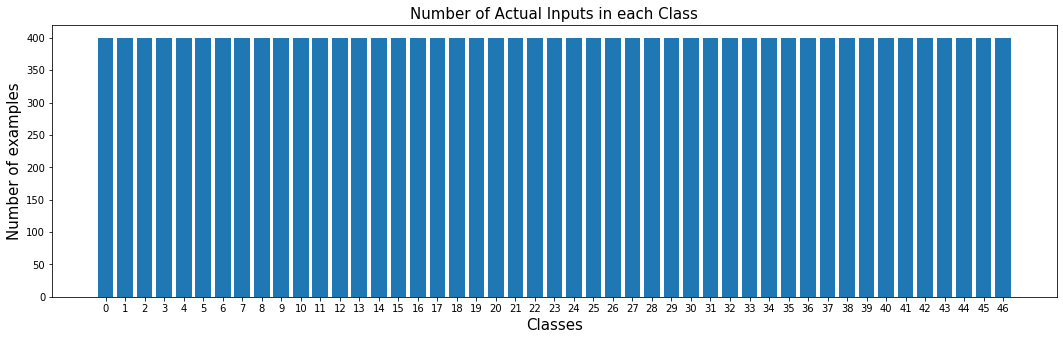

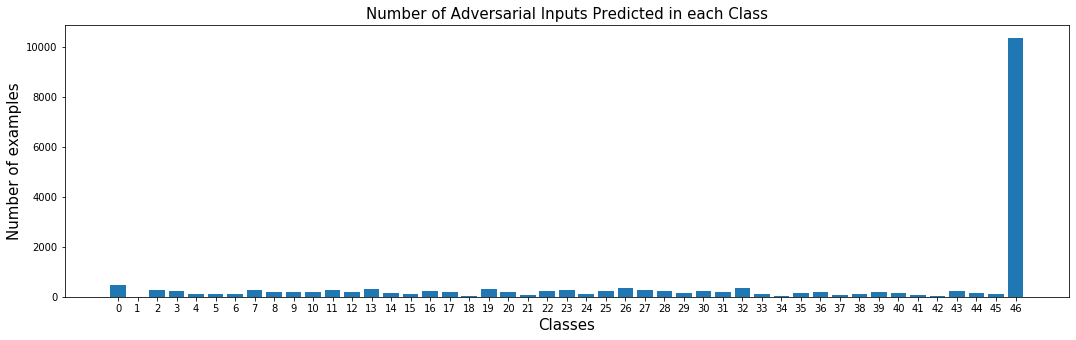

In [8]:
# Graphs to show how adversarial examples shift the prediction of model
unique_elements, counts_elements = np.unique(y_val, return_counts=True)
outputClassesPlot(unique_elements, counts_elements, 47, "Number of Actual Inputs in each Class")


unique_elements, counts_elements = np.unique(np.argmax(y_val_adversarial_pred, axis=1), return_counts=True)
outputClassesPlot(unique_elements, counts_elements, 47, "Number of Adversarial Inputs Predicted in each Class")

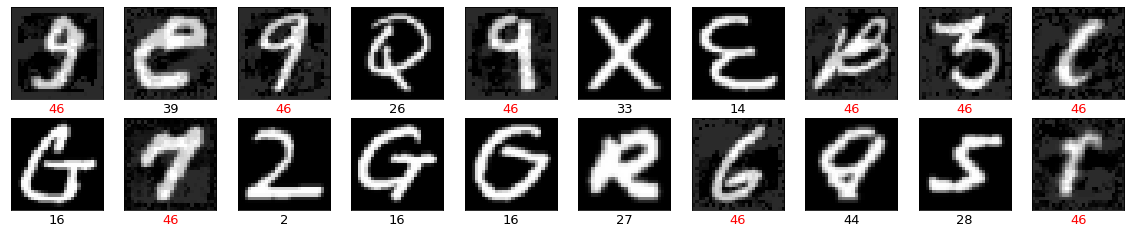

In [9]:
# Plot some test advarsarial examples examples
plt.figure(figsize=(20,20))
for i in range(20):
    plt.subplot(10,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_val_adversarial[i].reshape(28, 28, order='F'), cmap=plt.cm.gray)
    label =plt.xlabel(np.argmax(y_val_adversarial_pred[i]))
    label.set_size(13)
    if(np.argmax(y_val_adversarial_pred[i]) != y_val[i] and np.argmax(y_val_adversarial_pred[i]) == 46):
      label.set_color("red")  
plt.show()

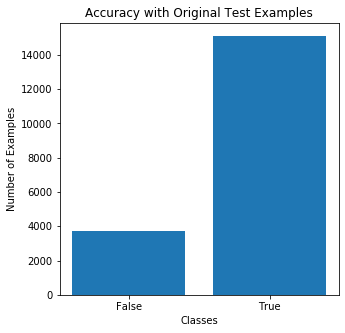

Accuracy of this model with given predicted values is 80.29255319148936 %


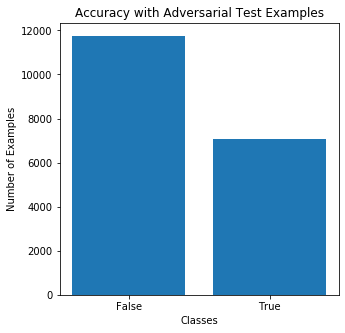

Accuracy of this model with given predicted values is 37.51063829787234 %


'37.51063829787234'

In [10]:
# Plot and findout accuracy of model with and without adversarial examples
# with original test examples
classifcationAccuracyPlot(np.argmax(y_val_pred, axis=1).reshape(-1, 1), y_val, "Accuracy with Original Test Examples")

# with adversarial test examples generated from original test examples
classifcationAccuracyPlot(np.argmax(y_val_adversarial_pred, axis=1).reshape(-1, 1), y_val, "Accuracy with Adversarial Test Examples")

Accuracy of this model with given predicted values is 31.75 %
Accuracy of this model with given predicted values is 31.765957446808514 %
Accuracy of this model with given predicted values is 31.765957446808514 %
Accuracy of this model with given predicted values is 37.51063829787234 %
Accuracy of this model with given predicted values is 45.276595744680854 %
Accuracy of this model with given predicted values is 63.744680851063826 %
Accuracy of this model with given predicted values is 78.38297872340425 %
Accuracy of this model with given predicted values is 80.0159574468085 %


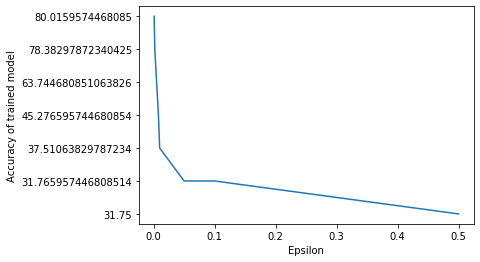

In [11]:
# Analysis of dependency of epsilon parameter on Adversarial Example Generation

# Let's test the accuracy of model with various values of epsilon
epsilon_values = [0.5, 0.1, 0.05, 0.01,  0.008, 0.005, 0.002, 0.001]
accuracy_values = []

for e in epsilon_values:
    target_label = 46 ## should be one of class labels 0 - 46 ##

    label = tf.one_hot(np.repeat(target_label, y_val_pred.shape[0]), y_val_pred.shape[-1])

    x_val_adversarial = fgsm_iterative(model, x_val, label, epsilon=e, epoch = 10)

    x_val_adversarial = x_val_adversarial.numpy()

    y_val_adversarial_pred = model.predict(x_val_adversarial)
    
    accuracy_values.append(classifcationAccuracyPlot(np.argmax(y_val_adversarial_pred, axis=1).reshape(-1, 1), y_val, "Accuracy with Adversarial Test Examples", False))

#Plot a graph between Epsilon values and Accuracy of model 
fig = plt.figure()
ax = plt.axes()
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 5

ax.plot(epsilon_values, accuracy_values)

plt.xlabel('Epsilon', fontsize=10)
plt.ylabel('Accuracy of trained model', fontsize=10)
plt.show()

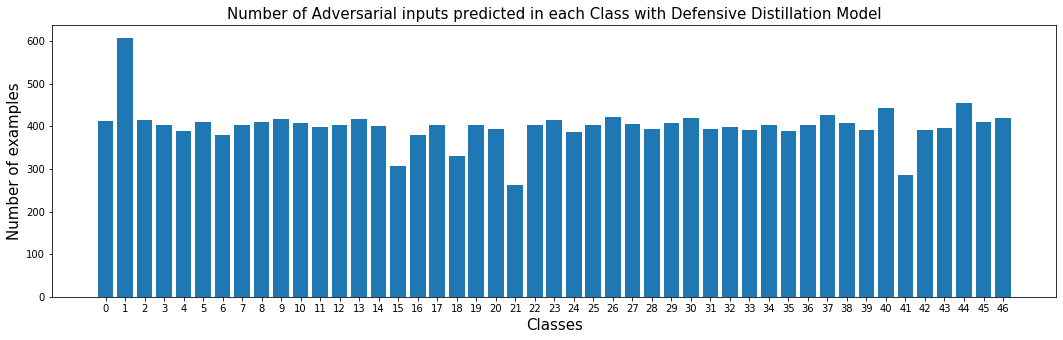

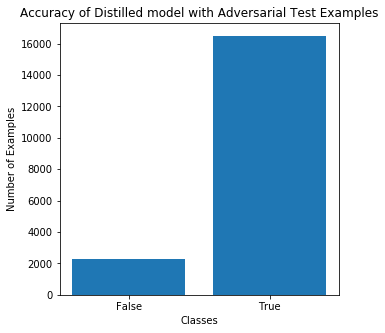

Accuracy of this model with given predicted values is 87.70212765957447 %


'87.70212765957447'

In [12]:
# Analysis of Defensive Distillation model with Adversarial examples.
distill_model = train_distillation(([],[]), ([],[]), 0, "models/distilled_model_T_100.h5")
y_val_adversarial_distill_pred = distill_model.predict(x_val_adversarial.reshape(x_val.shape[0], 28, 28, 1))

unique_elements, counts_elements = np.unique(np.argmax(y_val_adversarial_distill_pred, axis=1), return_counts=True)
outputClassesPlot(unique_elements, counts_elements, 47, "Number of Adversarial inputs predicted in each Class with Defensive Distillation Model")

# Calculate accuracy of Distilled Model
classifcationAccuracyPlot(np.argmax(y_val_adversarial_distill_pred, axis=1).reshape(-1, 1), y_val, "Accuracy of Distilled model with Adversarial Test Examples", True)

Accuracy of this model with given predicted values is 89.07446808510639 %
Accuracy of this model with given predicted values is 89.13829787234042 %
Accuracy of this model with given predicted values is 89.18617021276596 %
Accuracy of this model with given predicted values is 88.61702127659574 %
Accuracy of this model with given predicted values is 88.63297872340425 %
Accuracy of this model with given predicted values is 88.14893617021276 %
Accuracy of this model with given predicted values is 88.25 %
Accuracy of this model with given predicted values is 87.68617021276596 %
[0.06382978723402744, 0.11170212765956933, -0.4574468085106531, -0.44148936170213915, -0.9255319148936252, -0.824468085106389, -1.3882978723404307]
89.07446808510639


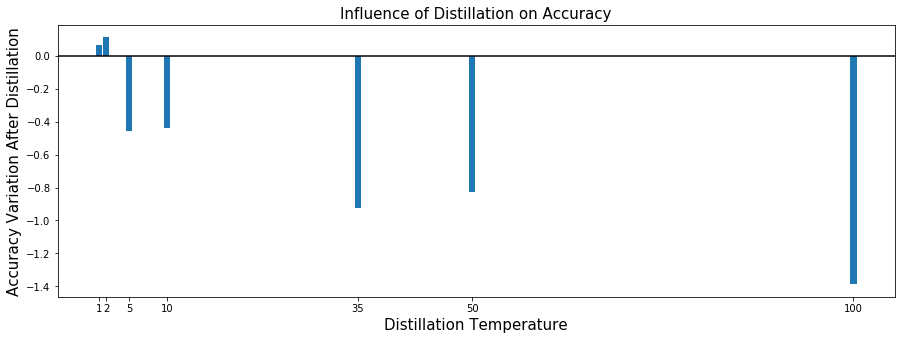

In [13]:
# Analysis of Distillation on Classification accuracy
undistilled_model = train_distillation(([],[]), ([],[]), 0, "models/undistilled_model_T_1.h5")
undistilled_distill_pred = undistilled_model.predict(x_val.reshape(x_val.shape[0], 28, 28, 1))
undistilled_distill_accu = classifcationAccuracyPlot(np.argmax(undistilled_distill_pred, axis=1).reshape(-1, 1), y_val, "", False)

# list of distilled models at diffrent temperatures
distilled_models_with_different_T = ["models/distilled_model_T_1.h5",
                                     "models/distilled_model_T_2.h5",
                                     "models/distilled_model_T_5.h5",
                                     "models/distilled_model_T_10.h5",
                                     "models/distilled_model_T_35.h5",
                                     "models/distilled_model_T_50.h5",
                                     "models/distilled_model_T_100.h5"]
accuracy_list = []

for model_t in distilled_models_with_different_T:
    distill_model = train_distillation(([],[]), ([],[]), 0, model_t)
    y_val_adversarial_distill_pred = distill_model.predict(x_val.reshape(x_val.shape[0], 28, 28, 1))
    accuracy_list.append(classifcationAccuracyPlot(np.argmax(y_val_adversarial_distill_pred, axis=1).reshape(-1, 1), y_val, "Accuracy with Adversarial Test Examples", False))

temperature = [1, 2, 5, 10, 35, 50, 100]
accuracy_updated = [(float(x) - float(undistilled_distill_accu)) for x in accuracy_list]
print(accuracy_updated)
print(undistilled_distill_accu)


# Plot a graph between Distillation temperature and Accuracy Variation After Distillation
fig, ax = plt.subplots(figsize=(15,5))
plt.bar(temperature, accuracy_updated)
plt.xlabel('Distillation Temperature', fontsize=15)
plt.ylabel('Accuracy Variation After Distillation', fontsize=15)
plt.title('Influence of Distillation on Accuracy', fontsize=15)
plt.xticks(temperature, temperature, fontsize=10, rotation=0)
ax.axhline(y=0, color='k')
plt.show()

Accuracy of this model with given predicted values is 66.0 %
Accuracy of this model with given predicted values is 67.0 %
Accuracy of this model with given predicted values is 68.0 %
Accuracy of this model with given predicted values is 70.0 %
Accuracy of this model with given predicted values is 71.0 %
Accuracy of this model with given predicted values is 75.0 %
Accuracy of this model with given predicted values is 83.0 %


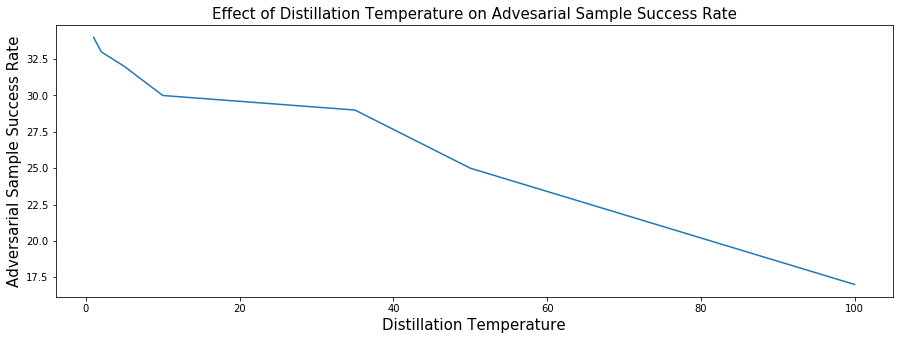

In [14]:
# Impact of Distillation Temperature on success rate of adversarial samples
distill_model = train_distillation(([],[]), ([],[]), 0, "models/undistilled_model_T_1.h5")

# list of distilled models at diffrent temperatures
distilled_models_with_different_T = ["models/distilled_model_T_1.h5",
                                     "models/distilled_model_T_2.h5",
                                     "models/distilled_model_T_5.h5",
                                     "models/distilled_model_T_10.h5",
                                     "models/distilled_model_T_35.h5",
                                     "models/distilled_model_T_50.h5",
                                     "models/distilled_model_T_100.h5"]

temperature = [1, 2, 5, 10, 35, 50, 100]


#Targetted Attack
target_label = 46 ## should be one of class labels 0 - 46 ##

#extracting first hunderd samples
x_val_set = x_val[0:100, :]
y_val_set = y_val[0:100, :]

#creating one hot encoded tensor with target_label
label = tf.one_hot(np.repeat(target_label, x_val_set.shape[0]), 47)

x_val_adversarial = fgsm_iterative(distill_model, x_val_set.reshape(x_val_set.shape[0], 28, 28, 1), label, epsilon=0.2, epoch = 15)

x_val_adversarial = x_val_adversarial.numpy()

accuracy_list = []

for model_t in distilled_models_with_different_T:
    distill_model = train_distillation(([],[]), ([],[]), 0, model_t)
    y_val_adversarial_distill_pred = distill_model.predict(x_val_adversarial.reshape(x_val_set.shape[0], 28, 28, 1))
    accuracy_list.append(classifcationAccuracyPlot(np.argmax(y_val_adversarial_distill_pred, axis=1).reshape(-1, 1), y_val_set, "Accuracy with Adversarial Test Examples", False))

    
accuracy_list = [(100 - float(x)) for x in accuracy_list]

# Plot a graph between Distillation temperature and Adversarial Sample Success Rate
index = np.arange(100)
unique_elements, counts_elements = np.unique(y_val, return_counts=True)
index = np.arange(47)
plt.subplots(figsize=(15,5))
plt.plot(temperature, accuracy_list)
plt.xlabel('Distillation Temperature', fontsize=15)
plt.ylabel('Adversarial Sample Success Rate', fontsize=15)
plt.title('Effect of Distillation Temperature on Advesarial Sample Success Rate', fontsize=15)
plt.show()

In [19]:
# l-infinity attack and its analysis with Distilled model at different temperatures.
with tf.compat.v1.Session() as sess:
    model = train_distillation(([],[]), ([],[]), 0, "models/undistilled_model_T_1.h5")
    random_sample = randrange(x_val.shape[0])
    inputs = (x_val[random_sample].reshape(28, 28, order='F')).reshape(1, 28, 28, 1)
    targets = np.eye(1, 47)
    l_infinity_attack = CarliniLi(sess, model, max_iterations=1000, initial_const=10, largest_const=15)
    #l_infinity_attack = CarliniL0(sess, model, input_data_shape, output_data_shape, max_iterations=1000, initial_const=10, largest_const=15)
    #l_infinity_attack = CarliniL2(sess, model, batch_size=1, max_iterations=1000, confidence=0)
    adv = l_infinity_attack.attack(inputs, targets)

# Check if attack works for all Distillation Temperature values
verifyAttack(adv, random_sample, y_val, "L-Infinity")

try const 10
0 (0.18540677, 0.018540677, 0.0)
Tau 0.08437408518557454
try const 10
0 (0.9846291, 0.09324361, 0.052193046)
100 (0.64678407, 0.06460423, 0.00074175)
200 (0.56233597, 0.056225702, 7.888675e-05)
300 (0.54393196, 0.05431759, 0.00075607)
400 (0.5371526, 0.053710703, 4.553795e-05)
500 (0.5131951, 0.05127368, 0.0004583001)
600 (0.46639043, 0.046607047, 0.00031995028)
700 (0.44156006, 0.044155322, 6.824732e-06)
800 (0.42424464, 0.04234852, 0.00075944513)
900 (0.41000846, 0.040970124, 0.00030723214)
Distillation Model distilled_model_T_1.h5 predicted label: [3] True Label: [32]. Distillation Model failed to correctly classify adversarial image.
Distillation Model distilled_model_T_2.h5 predicted label: [3] True Label: [32]. Distillation Model failed to correctly classify adversarial image.
Distillation Model distilled_model_T_5.h5 predicted label: [3] True Label: [32]. Distillation Model failed to correctly classify adversarial image.
Distillation Model distilled_model_T_10.h5 pr

In [20]:
# l-0 attack and its analysis with Distilled model at different temperatures.
with tf.compat.v1.Session() as sess:
    model = train_distillation(([],[]), ([],[]), 0, "models/undistilled_model_T_1.h5")
    random_sample = randrange(x_val.shape[0])
    inputs = (x_val[random_sample].reshape(28, 28, order='F')).reshape(1, 28, 28, 1)
    targets = np.eye(1, 47)
    l_0_attack = CarliniL0(sess, model, max_iterations=1000, initial_const=10, largest_const=15)
    #l_infinity_attack = CarliniL2(sess, model, batch_size=1, max_iterations=1000, confidence=0)
    adv = l_0_attack.attack(inputs, targets)
    
# Check if attack works for all Distillation Temperature values
verifyAttack(adv, random_sample, y_val, "L-0")

Attack iteration 0
try const 10
0 [0.] 0.0
Forced equal: 0.0 Equal count: 0
Now forced equal: 1.0
try const 10
0 [0.] 3.9665563e-11
Forced equal: 1.0 Equal count: 0
Now forced equal: 1.0
try const 10
0 [0.] 1.4163559e-10
Forced equal: 1.0 Equal count: 0
Now forced equal: 1.0
try const 10
0 [0.] 3.067258e-10
Forced equal: 1.0 Equal count: 0
Now forced equal: 1.0
try const 10
0 [0.] 5.3574956e-10
Forced equal: 1.0 Equal count: 0
Now forced equal: 1.0
try const 10
0 [0.] 8.687042e-10
Forced equal: 1.0 Equal count: 0
Now forced equal: 1.0
try const 10
0 [0.] 1.3737969e-09
Forced equal: 1.0 Equal count: 0
Now forced equal: 1.0
try const 10
0 [0.] 1.9968525e-09
Forced equal: 1.0 Equal count: 0
Now forced equal: 1.0
try const 10
0 [0.] 2.4679019e-09
Forced equal: 1.0 Equal count: 0
Now forced equal: 1.0
try const 10
0 [0.] 3.061822e-09
Forced equal: 1.0 Equal count: 0
Now forced equal: 1.0
try const 10
0 [0.] 3.799858e-09
Forced equal: 1.0 Equal count: 0
Now forced equal: 1.0
try const 10
0 [

In [417]:
# l-2 attack and its analysis with Distilled model at different temperatures.
with tf.compat.v1.Session() as sess:
    model = train_distillation(([],[]), ([],[]), 0, "models/undistilled_model_T_1.h5")
    random_sample = randrange(x_val.shape[0])
    inputs = (x_val[random_sample].reshape(28, 28, order='F')).reshape(1, 28, 28, 1)
    targets = np.eye(1, 47)
    l_2_attack = CarliniL2(sess, model, batch_size=1, max_iterations=1000, confidence=0)
    adv = l_2_attack.attack(inputs, targets)
    
# Check if attack works for all Distillation Temperature values
verifyAttack(adv, random_sample, y_val, "L-2")

go up to 1
tick 0
[10000000000.0]
0 (0.0010805685, 0.00010474364, 0.0009758249)
100 (0.00010632673, 0.000106311476, 1.5248661e-08)
[10000000000.0]
0 (0.0015601658, 0.0, 0.0015601658)
100 (3.5847356e-06, 3.531538e-06, 5.31978e-08)
200 (3.5711153e-06, 3.5183502e-06, 5.2765e-08)
300 (3.5709818e-06, 3.5180897e-06, 5.2892233e-08)
[0.00028004718]
0 (0.0017251265, 0.0002617263, 0.0014634002)
100 (0.0002704684, 0.00027042712, 4.1270514e-08)
[0.00028004718]
0 (0.0021920076, 0.00071514276, 0.0014768648)
100 (0.00072480354, 0.00072475465, 4.8893156e-08)
[0.00028004718]
0 (0.0018021807, 0.0002893706, 0.0015128101)
100 (0.00030040712, 0.00030034457, 6.254801e-08)
200 (0.000300393, 0.00030033095, 6.2054696e-08)
[0.00028004718]
0 (0.0, 0.0, 0.0)
100 (0.0, 0.0, 0.0)
200 (0.0, 0.0, 0.0)
300 (0.0, 0.0, 0.0)
400 (0.0, 0.0, 0.0)
500 (0.0, 0.0, 0.0)
600 (0.0, 0.0, 0.0)
700 (0.0, 0.0, 0.0)
800 (0.0, 0.0, 0.0)
900 (0.0, 0.0, 0.0)
[0.0]
0 (0.002651507, 0.001137631, 0.001513876)
100 (0.0011514698, 0.001151378,